### Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

## Retail Ecommerce Sales data

In [2]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')

In [3]:
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]

In [4]:
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])

In [5]:
retailEcommercesales.dtypes

REF_DATE    object
VALUE        int64
dtype: object

In [11]:
retailEcommercesales['REF_DATE'] = pd.to_datetime(retailEcommercesales['REF_DATE'], format='%Y/%m/%d %I:%M:%S %p')

In [12]:
retailEcommercesales.head(2)

,REF_DATE,VALUE
3,2016-01-01,977198
7,2016-02-01,1006610


## Time series plot of Retail Ecommerce Sales

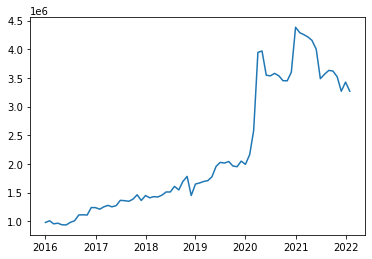

In [13]:
retailEcommercesales_dup = retailEcommercesales.copy()
retailEcommercesales_dup.index=retailEcommercesales_dup['REF_DATE']
plt.plot(retailEcommercesales_dup['VALUE'])
plt.show()